## Imports

In [1]:
import pandas as pd
from lifetimes.utils import summary_data_from_transaction_data
import numpy as np
import datetime
from lifetimes import ModifiedBetaGeoFitter
from dateutil.relativedelta import relativedelta
from lifetimes import GammaGammaFitter
import os
import matplotlib.pyplot as plt
import dask.dataframe as dd
from dask.multiprocessing import get
import boto3
from multiprocessing import cpu_count
import pickle
import s3fs
from melitk.analytics.connectors.core.authentication import Authentication
from melitk.analytics.connectors.teradata import ConnTeradata
from melitk.analytics.connectors.presto import ConnPresto
from melitk.fda import workspace
import datetime
from dateutil.relativedelta import relativedelta


cores = 20

In [2]:
def asigno_quintiles_5(x):
    step = int(x.shape[0]*0.2)
    l_= []
    for i in range(4):
        l_ = l_ + [i+1]*step
    l_ = l_ + [5]*(x.shape[0] - len(l_)) 
    return l_   

# Util para escribir un df en s3
def _write_dataframe_to_csv_on_s3(df, path_s3):
    import boto3
    from io import StringIO
    """ Write a dataframe to a CSV on S3 """
    a = path_s3.split('//')
    b = a[1].split('/')
    bucket = b[0]
    c = path_s3.split(bucket+'/')
    path = c[1]
    
    buffer = StringIO()
    df.to_csv(buffer)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, path).put(Body=buffer.getvalue())
    return None

## Levanto todos los paises y calculo con BTYD

In [3]:
today = datetime.datetime.today()
today = datetime.datetime(today.year,today.month,1)

/alloc/data/fury_ltv-ml/training/MLM
/alloc/data/fury_ltv-ml/training/MLM
from:  2017-10-01 00:00:00 ,to:  2019-10-01 00:00:00
summary OK
      fun: -6.2091968464664
 hess_inv: array([[ 17.62038595,  12.56679434,  -3.94898096, -35.30146746],
       [ 12.56679434,  11.66709049,  -3.62943122, -22.76697158],
       [ -3.94898096,  -3.62943122,  35.76342308,  47.69258813],
       [-35.30146746, -22.76697158,  47.69258813, 142.01846802]])
      jac: array([-1.23316600e-07,  1.23976698e-07,  2.65310007e-08, -1.87208048e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 83
      nit: 27
     njev: 71
   status: 2
  success: False
        x: array([-0.22887882, -2.48845824, -1.92917159, -0.17274758])
fit OK


/usr/local/lib/python3.5/site-packages/dask/dataframe/core.py:3981: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))
/usr/local/lib/python3.5/site-packages/dask/dataframe/core.py:3981: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warni

pareto OK
gamagama OK
/alloc/data/fury_ltv-ml/training/MCO
/alloc/data/fury_ltv-ml/training/MCO
from:  2017-10-01 00:00:00 ,to:  2019-10-01 00:00:00
summary OK
fit OK


/usr/local/lib/python3.5/site-packages/dask/dataframe/core.py:3981: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))
/usr/local/lib/python3.5/site-packages/dask/dataframe/core.py:3981: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warni

pareto OK
gamagama OK
/alloc/data/fury_ltv-ml/training/MLU
/alloc/data/fury_ltv-ml/training/MLU
from:  2017-10-01 00:00:00 ,to:  2019-10-01 00:00:00
summary OK
fit OK


/usr/local/lib/python3.5/site-packages/dask/dataframe/core.py:3981: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))
/usr/local/lib/python3.5/site-packages/dask/dataframe/core.py:3981: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warni

pareto OK
gamagama OK


<Figure size 720x720 with 0 Axes>

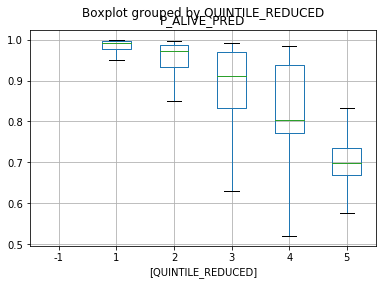

<Figure size 720x720 with 0 Axes>

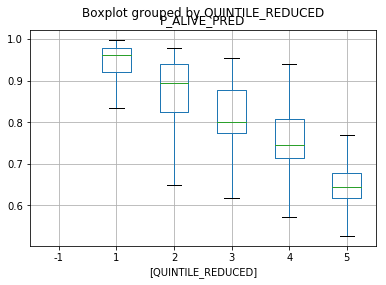

<Figure size 720x720 with 0 Axes>

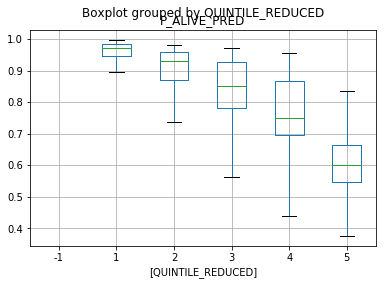

In [9]:
paises = ['MLB','MLA','MLC','MLM','MCO','MLU']
for PAIS in paises: 
    # Creo una carpeta donde guardar los modelos y imagen de boxplot
    dir_pais = os.path.join(os.path.dirname(os.path.abspath('__file__')),PAIS)
    print(dir_pais)
    if(not os.path.exists(dir_pais)):
        os.mkdir(dir_pais)
    print(dir_pais)

    country = pd.read_csv("s3://fda-labs/ltv-ml/ML/Raw_" + PAIS +"_1_"+ today.strftime("%Y-%m-%d")+".csv",sep = '|')
    country = country.append(pd.read_csv("s3://fda-labs/ltv-ml/ML/Raw_" + PAIS +"_2_"+ today.strftime("%Y-%m-%d")+".csv",sep = '|'), ignore_index = True)

    country.columns = ["date","cust","sales","CATEG_L1","CATEG_L2","CATEG_L3"]
    country["date"] = pd.to_datetime(country["date"],infer_datetime_format=True,errors = "coerce")
    # check la amplitud de data
    print('from: ',country.date.min(),',to: ',country.date.max())
    
    today = country.date.max()
    # Me genero el input dle modelo
    summary_cal = summary_data_from_transaction_data(country, 'cust', 'date', freq='W',
                                                     monetary_value_col='sales',  # le saca la primer compra (semana de compras) y toma el promedio agrupado por semana (frequency)
                                                     observation_period_end=today.strftime("%Y-%m-%d"))   
    print("summary OK")
    # Calculo los casos que churnearon pero no los uso!
    churneros = country.groupby('cust')["date"].agg('max').reset_index()
    churneros["my_recency"] = (today - churneros["date"])/np.timedelta64(1, "W") # me genero el recency y la semanalizo
    summary_cal = pd.merge(summary_cal,churneros[["cust","my_recency"]],on = "cust",how = "left")
    churneros = churneros.loc[churneros["my_recency"] > 52] # si el usuario no realizo una compra en 1 año, churnea

    churneros2 = pd.merge(churneros, country.groupby(['cust'])["sales"].size().reset_index() ,on="cust",how = "left")
    churneros2 = churneros2.loc[churneros2["sales"] <= 1]

    # Entreno el modelo
    bgf = ModifiedBetaGeoFitter()
    try:
        bgf.fit(summary_cal['frequency'], summary_cal['recency'], summary_cal['T'])
    except:
        bgf = ModifiedBetaGeoFitter(penalizer_coef=0.1)
        bgf.fit(summary_cal['frequency'], summary_cal['recency'], summary_cal['T']) 
        
    bgf.save_model(os.path.join(dir_pais,'bgf_'+PAIS+'.pkl'))
    print("fit OK")
    # aplico sobre datos no vistos, luego para comparar me quedo con los usuarios que estan en validacion!
    summary_cal["n_purchases_pred"] = dd.from_pandas(summary_cal, npartitions=cores).apply(lambda x: bgf.conditional_expected_number_of_purchases_up_to_time(52, x['frequency'], x['recency'], x['T']),axis = 1).compute(scheduler='processes')
    summary_cal = summary_cal.reset_index()

    def apply_pAlive(x):  # hay modelos que devuelve una lista como proba, hay que hacer un unpak en estos casos
        y = bgf.conditional_probability_alive(x['frequency'], x['recency'], x['T'])
        if(type(y) == np.ndarray):
            return y[0]
        else:
            return y

    summary_cal["p_alive"] = dd.from_pandas(summary_cal, npartitions=cores).apply(lambda x: apply_pAlive(x),axis = 1).compute(scheduler='processes')
    print("pareto OK")
    # Calculo la guita que van a dar!! Fit-transform

    # Si imputo valores crashea ya que no puedo converger, intente moviendole el penalizer pero la cosa no mejora...
    summary_cal.loc[summary_cal["monetary_value"] == 0,"monetary_value"] = min(summary_cal.loc[summary_cal["monetary_value"] > 0]["monetary_value"])
    #summary_cal = summary_cal.loc[summary_cal["monetary_value"] > 0]
    ggf = GammaGammaFitter(penalizer_coef = 0)
    ggf.fit(summary_cal['frequency']+1,
            summary_cal['monetary_value'])

    resu = ggf.conditional_expected_average_profit(summary_cal['frequency']+1,
            summary_cal['monetary_value']).reset_index()

    resu.columns = ["ind","montary_sales_forecast"]
    summary_cal["montary_sales_forecast"] = resu["montary_sales_forecast"]
    # la cantidad de compras que le va a hacer el usuario en su año de vida es la cantidad de compras que hara * compras promedio
    summary_cal["clv"] = summary_cal["n_purchases_pred"]*summary_cal["montary_sales_forecast"] 
    # le saco a los usuarios churneros una vez entrenado el modelo
    summary_cal = summary_cal.loc[~summary_cal["cust"].isin(list(churneros.cust.values))]
    print("gamagama OK")

    #out_users = summary_cal.loc[~summary_cal.cust.isin(list(churneros2.cust.values))]
    out_users = summary_cal.sort_values(by = "n_purchases_pred",ascending=False)
    out_users["quintil"] = asigno_quintiles_5(out_users)
    out_users["SIT_SITE_ID"] = PAIS
    out_users["SUM_LOG_INTER_TX_TIMES"] = np.NAN
    out_users["SALES_PAST"] = np.NAN
    out_users["SALES_AVG_PRED"] = np.NAN
    out_users["SUM_LOG_INTER_TX_TIMES"] = np.NAN
    out_users["QUINTILE"] = np.NAN
    out_users["DECILE"] = np.NAN
    out_users["FB_DATE"] = np.NAN
    out_users["PHOTO_ID"] = str(today.year)+ str(today.month).zfill(2) 
    out_users = out_users.drop(["index"],axis = 1)

    out_users = out_users[["cust","SIT_SITE_ID","n_purchases_pred","frequency","recency","SUM_LOG_INTER_TX_TIMES","SALES_PAST","FB_DATE","T","p_alive","monetary_value","clv","QUINTILE","DECILE","PHOTO_ID","quintil"]]
    out_users.columns = ["CUS_CUST_ID","SIT_SITE_ID","X_DAYS_PRED","X_DAYS_PAST_MENOS_1","TIME_BETWEEN_FIRST_LAST","SUM_LOG_INTER_TX_TIMES","SALES_PAST","FB_DATE","TIME_BETWEEN_FIRST_TO_END_PERIOD","P_ALIVE_PRED","SALES_AVG_PAST","SALES_PRED","QUINTILE","DECILE","PHOTO_ID","QUINTILE_REDUCED"]
    out_users = out_users[["CUS_CUST_ID","SIT_SITE_ID","X_DAYS_PRED","X_DAYS_PAST_MENOS_1","TIME_BETWEEN_FIRST_LAST","TIME_BETWEEN_FIRST_TO_END_PERIOD","P_ALIVE_PRED","SALES_AVG_PAST","SALES_PRED","PHOTO_ID","QUINTILE_REDUCED"]]
    
    pp = pd.DataFrame([],columns = out_users.columns)
    pp["CUS_CUST_ID"] = churneros["cust"]
    pp["QUINTILE_REDUCED"] = -1

    out_users = out_users.append(pp,ignore_index=True)
    today_1 = today - relativedelta(months=1)
    out_users["PHOTO_ID"] = str(today_1.year)+ str(today_1.month).zfill(2) 
    
    out_users["TIME_BETWEEN_FIRST_LAST"] = out_users["TIME_BETWEEN_FIRST_LAST"].apply(lambda x: round(x,4))
    out_users["P_ALIVE_PRED"] = out_users["P_ALIVE_PRED"].apply(lambda x: round(x,4))
    out_users["SALES_AVG_PAST"] = out_users["SALES_AVG_PAST"].apply(lambda x: round(x,4))
    out_users["SALES_PRED"] = out_users["SALES_PRED"].apply(lambda x: round(x,4))
    out_users["X_DAYS_PRED"] = out_users["X_DAYS_PRED"].apply(lambda x: round(x,4))
    out_users["SIT_SITE_ID"] = PAIS
    
    _write_dataframe_to_csv_on_s3(out_users,"s3://fda-labs/ltv-ml/ML/"+PAIS+"/out_"+today.strftime("%Y-%m-%d")+".csv")

    # Self check: La idea es que cada boxplot quede separado en su mediana (esperado, no siempre se da tan claro)
    fig=plt.figure(figsize=(10, 10))
    out_users[["P_ALIVE_PRED","QUINTILE_REDUCED"]].boxplot(by= "QUINTILE_REDUCED",showfliers=False)
    plt.savefig('boxPlot_palive.png')
    
    s3 = boto3.client('s3')
    s3.upload_file('boxPlot_palive.png', "fda-labs", "ltv-ml/ML/"+PAIS+"/boxPlot_palive.png")

In [ ]:
teradata_user_app = os.environ['SECRET_TERADATA_USER_APP_MP']
teradata_pass_app = os.environ['SECRET_TERADATA_PASS_APP_MP']

teradata_user_ldap = os.environ['SECRET_TERADATA_USER_APP']
teradata_pass_ldap = os.environ['SECRET_TERADATA_PASS_APP']

s3_access_key = os.environ['SECRET_S3_KEY']
s3_secret_key = os.environ['SECRET_S3_SECRET']

In [ ]:
today = datetime.datetime.today()
today = datetime.datetime(today.year,today.month,1)
past_1 = today - relativedelta(months = 1)

In [ ]:
tera = ConnTeradata(teradata_user_ldap, teradata_pass_ldap, auth_method=Authentication.APP)

tera.execute(""" drop table mkt_corp.PZ_TMP_LTV_ML""")

tera.execute("""

    CREATE MULTISET TABLE mkt_corp.PZ_TMP_LTV_ML,
     NO BEFORE JOURNAL,
     NO AFTER JOURNAL,
     CHECKSUM = DEFAULT,
     DEFAULT MERGEBLOCKRATIO
     (
        CUS_CUST_ID varchar(200),
        SIT_SITE_ID varchar(4),
        X_DAYS_PRED decimal(18,4),
        X_DAYS_PAST_MENOS_1 integer,
        TIME_BETWEEN_FIRST_LAST decimal(18,4),
        TIME_BETWEEN_FIRST_TO_END_PERIOD decimal(18,4),
        P_ALIVE_PRED decimal(18,4),
        SALES_AVG_PAST decimal(18,4),
        SALES_PRED decimal(18,4),        
        PHOTO_ID varchar(10),
        QUINTILE_REDUCED integer

      )PRIMARY INDEX ( CUS_CUST_ID,SIT_SITE_ID );   

                """)
    
for PAIS in ['MLB','MLC','MLM','MCO','MLU','MLA']:

    out = pd.read_csv("s3://fda-labs/ltv-ml/ML/"+PAIS+"/out_"+today.strftime("%Y-%m-%d")+".csv")
    out = out[['CUS_CUST_ID', 'SIT_SITE_ID', 'X_DAYS_PRED', 'X_DAYS_PAST_MENOS_1', 'TIME_BETWEEN_FIRST_LAST',
               'TIME_BETWEEN_FIRST_TO_END_PERIOD', 'P_ALIVE_PRED', 'SALES_AVG_PAST','SALES_PRED', 'PHOTO_ID',
               'QUINTILE_REDUCED']]   

    out.to_csv("to_tera.csv",index = False)
    print("guardado")
    
    tera = ConnTeradata(teradata_user_app, teradata_pass_app, auth_method=Authentication.APP) # me conecto con otro aplicativo, problema de permisos

    tera.fast_load(file_path="to_tera.csv",table = "mkt_corp.PZ_TMP_LTV_ML",sep = ",")

    !rm -R to_tera.csv  # borro el archivo

In [ ]:

tera = ConnTeradata(teradata_user_app, teradata_pass_app, auth_method=Authentication.APP)
tera.execute("""
   SET QUERY_BAND = 'BLOCKCOMPRESSION=YES;' FOR TRANSACTION;

   INSERT INTO mkt_corp.NG_LTV_ALL_SITES_HIST
       SELECT  CAST(CUS_CUST_ID as varchar(200)),
               CAST( SIT_SITE_ID as CHAR(3)),
               CAST( X_DAYS_PAST_MENOS_1 as decimal(18,4)),
               CAST( TIME_BETWEEN_FIRST_LAST as decimal(18,4)),
               NULL,
               NULL,
               NULL,
               CAST( TIME_BETWEEN_FIRST_TO_END_PERIOD as decimal(18,4)),
               CAST( X_DAYS_PRED as decimal(18,4)),
               CAST( P_ALIVE_PRED as decimal(18,4)),
               CAST( SALES_AVG_PAST as decimal(18,4)),
               NULL,
               CAST( SALES_PRED as decimal(18,4)),
               NULL,
               NULL,
               CAST( PHOTO_ID as varchar(20)),
               CAST( QUINTILE_REDUCED as integer)
            FROM mkt_corp.PZ_TMP_LTV_ML
        """)

In [ ]:
# Muestro lo que se cargo para ver que no haya
tera = ConnTeradata(teradata_user_ldap, teradata_pass_ldap, auth_method=Authentication.APP)

print("Muesto cantidad insertada:")
print(pd.DataFrame(tera.execute_response(""" 
                    select SIT_SITE_ID,photo_id, count(*) as cant_Transac 
                    from mkt_corp.NG_LTV_ALL_SITES_HIST
                    group by SIT_SITE_ID,photo_id
                    order by photo_id DESC""")).head(12))

print("sample")
print(pd.DataFrame(tera.execute_response(""" 
                    select *
                    from mkt_corp.NG_LTV_ALL_SITES_HIST
                    where photo_id = '"""+ past_1.strftime("%Y%m") + """'  
                    sample 10""")))